# ParkSense: Full Dataset Analysis (EDA)

**Goal**: Deep dive into the FULL 2019 dataset (~2.6 Million rows).

**Visualizations**:
1.  **Date Range**: Verify effective coverage.
2.  **Occupancy by Hour**: Colored peaks.
3.  **Geospatial Heatmap**: Interactive map on Melbourne streets.
4.  **Duration & Balance**: Validating assumptions on the full scale.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Full Data
Loading the processed file (might take ~30s).

In [6]:
DATA_PATH = '../data/processed_parking_data_full.csv'
print("Loading full dataset...")
df = pd.read_csv(DATA_PATH, parse_dates=['Arrival_Time'])
print(f"Loaded {df.shape[0]:,} rows.")

Loading full dataset...
Loaded 400,809 rows.


## 2. Date Range Coverage

In [7]:
min_date = df['Arrival_Time'].min()
max_date = df['Arrival_Time'].max()

print(f"Start Date: {min_date}")
print(f"End Date:   {max_date}")
print(f"Total Days: {(max_date - min_date).days}")

Start Date: 2019-01-01 00:00:00
End Date:   2019-12-31 23:48:53
Total Days: 364


## 3. Hourly Occupancy (Highlighted Peaks)
We visualize the rush hour with color intensity.

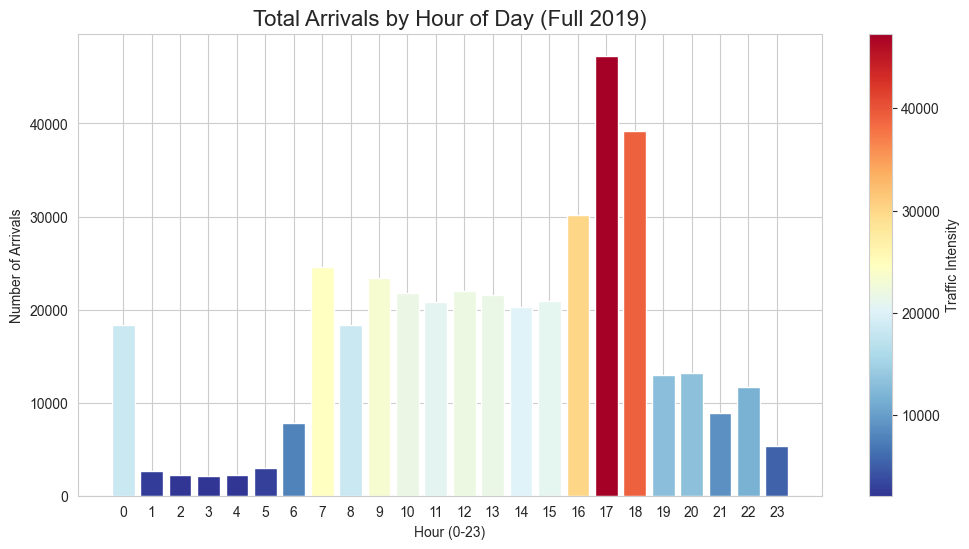

In [8]:
hourly_counts = df.groupby('hour').size()

# Color map: Unbusy = Light Blue, Busy = Dark Red
norm = plt.Normalize(hourly_counts.min(), hourly_counts.max())
colors = plt.cm.RdYlBu_r(norm(hourly_counts.values))

plt.figure(figsize=(12, 6))
bars = plt.bar(hourly_counts.index, hourly_counts.values, color=colors)
plt.title('Total Arrivals by Hour of Day (Full 2019)', fontsize=16)
plt.xlabel('Hour (0-23)')
plt.ylabel('Number of Arrivals')
plt.xticks(range(0, 24))

# Add color bar for reference
sm = plt.cm.ScalarMappable(cmap='RdYlBu_r', norm=norm)
sm.set_array([])
# Fix: Explicitly declare axis for colorbar
plt.colorbar(sm, ax=plt.gca(), label='Traffic Intensity')

plt.show()

## 4. Geospatial Heatmap (Interactive)
We use `folium` to plot valid sensor locations on a real map of Melbourne.
We take a SAMPLE (e.g. 10k points) to avoid crashing the browser, but weights are based on frequency.

In [9]:
# Get unique locations and their 'popularity' (count of arrivals)
location_counts = df.groupby(['Latitude', 'Longitude']).size().reset_index(name='count')

# Start map at Melbourne CBD
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=14)

# Add Heatmap
HeatMap(
    data=location_counts[['Latitude', 'Longitude', 'count']].values,
    radius=10,
    blur=15,
    max_zoom=1
).add_to(m)

# Save map
m.save('melbourne_parking_heatmap.html')
m

**Note**: An HTML file `melbourne_parking_heatmap.html` has been saved. Open it to explore the map interactively.

## 5. Stay Duration (Full Scale)
Checking if the 'short stay' trend holds true for millions of cars.

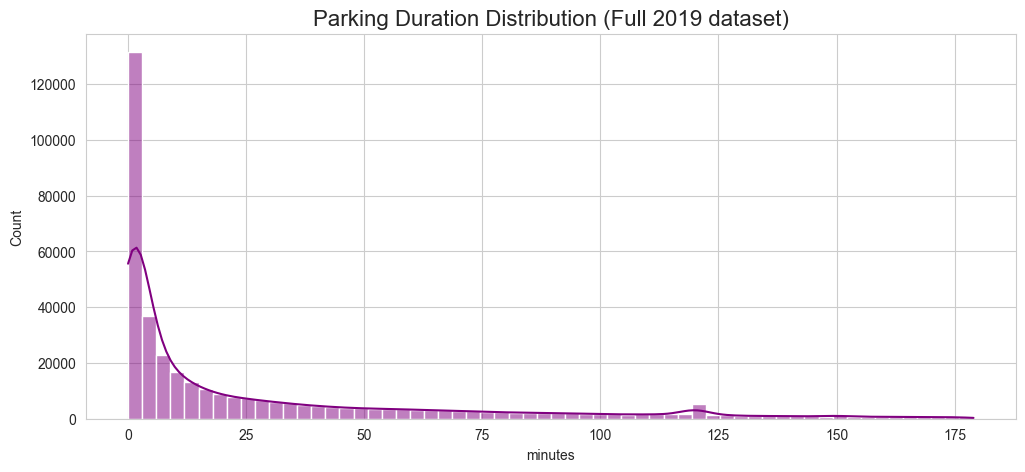

In [10]:
plt.figure(figsize=(12, 5))
# Cap at 3 hours
sns.histplot(df[df['duration_min'] < 180]['duration_min'], bins=60, color='purple', kde=True)
plt.title('Parking Duration Distribution (Full 2019 dataset)', fontsize=16)
plt.xlabel('minutes')
plt.show()

## 6. Target Variable Balance
Did including all data change the balance of Free vs Occupied?

is_free_15m
1    0.55136
0    0.44864
Name: proportion, dtype: float64


C:\Users\hsueh\AppData\Local\Temp\ipykernel_15324\773280219.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='coolwarm')


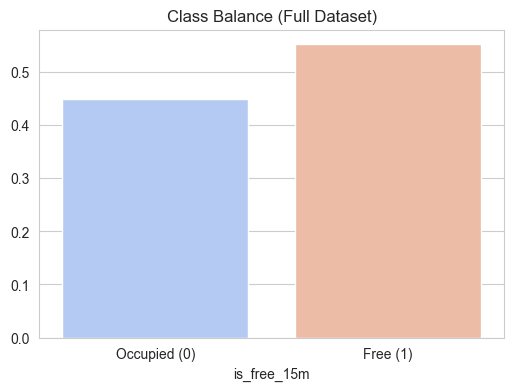

In [11]:
counts = df['is_free_15m'].value_counts(normalize=True)
print(counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=counts.index, y=counts.values, palette='coolwarm')
plt.title('Class Balance (Full Dataset)')
plt.xticks([0, 1], ['Occupied (0)', 'Free (1)'])
plt.show()